In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [2]:
import tensorflow as tf,matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.classifier_helper import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
from matplotlib import cm

### Load tracking data and check quality

In [18]:
minion = pk.load(open('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/deg/rpoA_timelapse_pos_6-1_tracker.pk','rb'))

/var/folders/wk/f42tr5tj0hq3sf4g8x9qng640000gn/T/ipykernel_2383/2098136419.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(3,3))


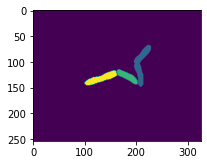

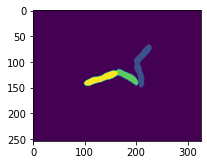

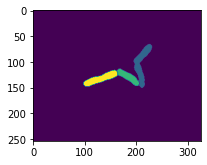

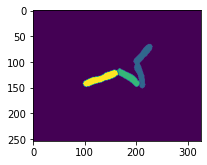

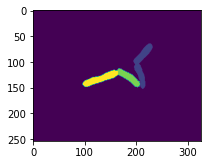

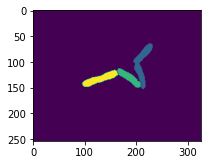

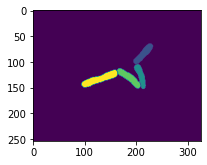

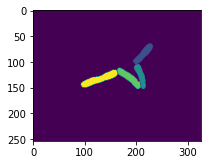

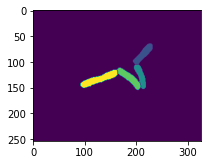

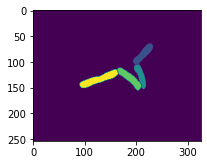

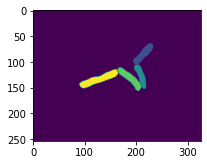

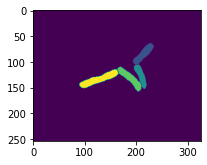

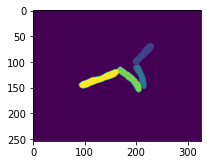

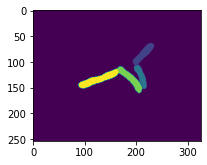

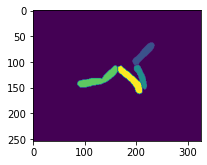

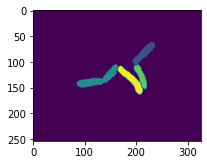

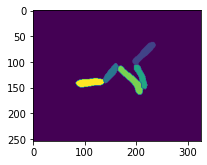

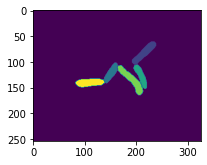

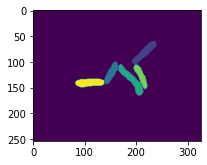

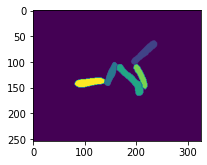

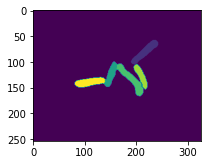

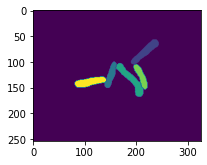

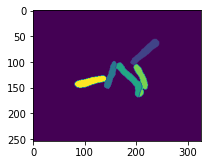

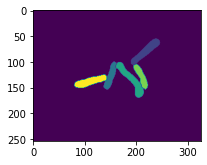

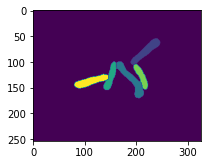

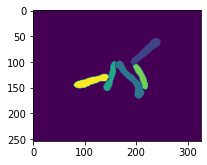

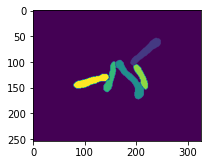

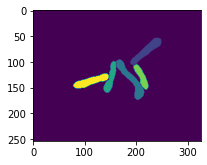

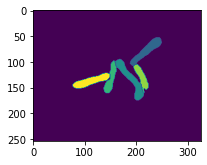

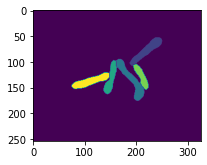

In [19]:
for i in range(30):
    fig=plt.figure(figsize=(3,3))
    plt.imshow(minion.frames[i].labeled_mask)

### Plot rpoA-eGFP intensity over time

In [ ]:
merged_regionprops = []
for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/deg/*.pk')):
    t = pk.load(open(f,'rb'))
    header = f.split('/')[-1].split('_tracker')[0]
    for p in t.frames:
        p.locate_particles(precompute_contours=True,
                       contour_kwargs={'level':0.12,'dilation':False})
        p.refine_contours(smooth_factor=3,smoothing='moving_window',approximate=False,
                          step_range=(-2.5,2.5),tol=0.2)
        p.extract_midlines()
        p.regionprops['$include']=1
        #"""
        p.filter_particles(filter_dict={})
        p.get_intensity_stats()
        #"""
    t.trace_lineage()
    t._update_regionprops()
    t.regionprops['Sample_ROI'] = header
    t.regionprops['Group'] = 'Deg'
    merged_regionprops.append(t.regionprops)


for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/control/*.pk')):
    t = pk.load(open(f,'rb'))
    header = f.split('/')[-1].split('_tracker')[0]
    for p in t.frames:
        p.locate_particles(precompute_contours=True,
                       contour_kwargs={'level':0.12,'dilation':False})
        p.refine_contours(smooth_factor=3,smoothing='moving_window',approximate=False,
                          step_range=(-2.5,2.5),tol=0.2)
        p.extract_midlines()
        p.regionprops['$include']=1
        #"""
        p.filter_particles(filter_dict={})
        p.get_intensity_stats()
        #"""
    t.trace_lineage()
    t._update_regionprops()
    t.regionprops['Sample_ROI'] = header
    t.regionprops['Group'] = 'Control'
    merged_regionprops.append(t.regionprops)
    
merged_regionprops = pd.concat(merged_regionprops)
merged_regionprops['Unique_Cell_id'] = ['{}@{}'.format(r,l) for l,r in zip(merged_regionprops['cell_lineage'].values,merged_regionprops['Sample_ROI'].values)]
pk.dump(merged_regionprops,open('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/merged_regionprops.pk','wb'))    

In [20]:
merged_regionprops = pk.load(open('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/merged_regionprops.pk','rb'))

In [ ]:
ctrl = merged_regionprops[merged_regionprops['Group']=='Control'].copy()
deg = merged_regionprops[merged_regionprops['Group']=='Deg'].copy()

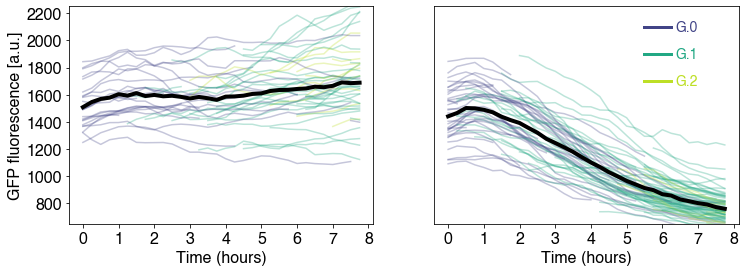

In [26]:
colors = [cm.get_cmap('viridis')(i) for i in [0.2,0.6,0.9]]
#colors = ['']
fig,axes = plt.subplots(figsize=(12,4),ncols=2)
for k in ctrl['Unique_Cell_id'].unique():
    subset = ctrl[ctrl['Unique_Cell_id']==k].copy()
    color = colors[k.count('.')]
    v = np.concatenate([[subset['C1_median'].values[0]],subset['C1_median'].values,[subset['C1_median'].values[-1]]])
    conv = np.convolve(v,np.ones(3)/3,mode='valid')
    axes[0].plot(subset['$time'].values,conv,color=color,alpha=0.3)
    axes[0].set_ylim(650,2250)
    
for k in deg['Unique_Cell_id'].unique():
    subset = deg[deg['Unique_Cell_id']==k].copy()
    v = np.concatenate([[subset['C1_median'].values[0]],subset['C1_median'].values,[subset['C1_median'].values[-1]]])
    conv = np.convolve(v,np.ones(3)/3,mode='valid')
    color = colors[k.count('.')]
    axes[1].plot(subset['$time'].values,conv,color=color,alpha=0.3)
    axes[1].set_ylim(650,2250)
    
grouped_ctrl = ctrl.groupby('$time').mean()
grouped_ctrl_std = ctrl.groupby('$time').std()
grouped_deg = deg.groupby('$time').mean()
grouped_deg_std = deg.groupby('$time').std()
axes[0].plot(grouped_ctrl.index,grouped_ctrl['C1_median'],lw=4,color='black')
axes[1].plot(grouped_deg.index,grouped_deg['C1_median'],lw=4,color='black')
axes[1].set_yticks([])
axes[0].set_xticks([i*4 for i in range(9)]);
axes[0].set_xticklabels([i for i in range(9)],fontsize=16,fontname='Helvetica');
axes[1].set_xticks([i*4 for i in range(9)]);
axes[1].set_xticklabels([i for i in range(9)],fontsize=16,fontname='Helvetica');
axes[0].set_yticks([800,1000,1200,1400,1600,1800,2000,2200])
axes[0].set_yticklabels([800,1000,1200,1400,1600,1800,2000,2200],fontsize=16,fontname='Helvetica');
axes[0].set_ylabel('GFP fluorescence [a.u.]',fontsize=16,fontname='Helvetica');
axes[0].set_xlabel('Time (hours)',fontsize=16,fontname='Helvetica');
axes[1].set_xlabel('Time (hours)',fontsize=16,fontname='Helvetica');
axes[1].plot([22,25],[2100,2100],color=colors[0],lw=3)
axes[1].plot([22,25],[1900,1900],color=colors[1],lw=3)
axes[1].plot([22,25],[1700,1700],color=colors[2],lw=3)
axes[1].text(25.5,2100,'G.0',color=colors[0],fontsize=14,fontname='Helvetica',va='center')
axes[1].text(25.5,1900,'G.1',color=colors[1],fontsize=14,fontname='Helvetica',va='center')
axes[1].text(25.5,1700,'G.2',color=colors[2],fontsize=14,fontname='Helvetica',va='center')
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/single_cell_tracking.svg',bbox_inches='tight')

### Load flow data

In [20]:
substrate_stat = pk.load(open('/Volumes/JZSSD_temp/202212_Harry_flow/substrate_stat_new.pk','rb'))

In [111]:
tl_time = np.arange(32)/4
tl_degradation = np.log2(grouped_deg['C1_mean'].values)
flow_time = np.array([0,3,6,9])

In [ ]:
tl_interp = np.interp(np.linspace(0,8,80),
                      np.linspace(0,8,32),
                      (tl_degradation-np.log2(350))/(tl_degradation[0]-np.log2(350)))

flow_interp = np.interp(np.linspace(0,9,90),
                      np.linspace(0,9,4),
                      substrate_stat[substrate_stat['Substrate']=='RpoA']['normalized_degradation'].values[0])



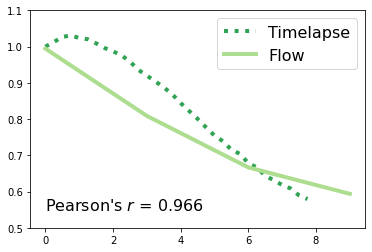

In [154]:
from scipy import stats
c1 = np.array([49,163,84])/255
c2 = np.array([173,221,142])/255
fig=plt.figure(figsize=(6,4))
plt.plot(tl_time,(tl_degradation-np.log2(350))/(tl_degradation[0]-np.log2(350)),color=c1,ls=':',lw=4,label='Timelapse')
plt.plot(flow_time,substrate_stat[substrate_stat['Substrate']=='RpoA']['normalized_degradation'].values[0],
         color=c2,ls='-',lw=4,label='Flow')
plt.legend(prop={'size':16})
plt.text(0,0.55,"Pearson's $r$ = {}".format(round(stats.pearsonr(tl_interp,flow_interp[:80])[0],3)),fontsize=16)
plt.ylim(0.5,1.1)
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/rpoA_timelapse/flow_timelapse_corr.svg',bbox_inches='tight')